In [407]:
def filter_short_ground_truths(df):
    """篩選 ground_truths_ans 長度小於2的資料列"""
    mask = df['ground_truths_ans'].apply(
        lambda x: len(x.split()) if isinstance(x, str) else (len(x) if isinstance(x, list) else 0)
    ) > 2
    return df[mask]


### 從單個 CSV 檔案讀取指定列並繪製折線圖

F1 Score - 平均: 0.1069, 最大: 1.0000, 最小: 0.0000


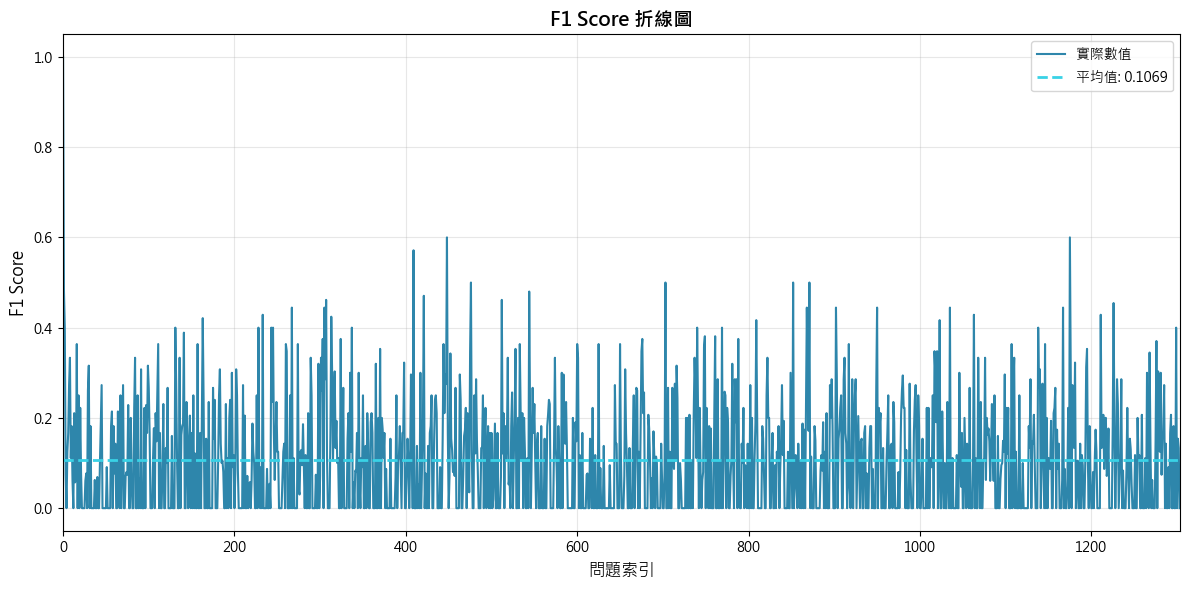

In [408]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
matplotlib.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'Arial Unicode MS']
matplotlib.rcParams['axes.unicode_minus'] = False

def plot_line_from_csv(csv_file, col_index=0, xlabel='索引', ylabel='數值', title='折線圖', header=None, adjustment=1, filter = True):
    """
    從 CSV 檔案讀取指定列並繪製折線圖
    
    參數:
        csv_file: CSV 檔案路徑
        col_index: 要繪製的列索引，預設為 0（第一列）
        xlabel: X 軸標籤，預設為 '索引'
        ylabel: Y 軸標籤，預設為 '數值'
        title: 圖表標題，預設為 '折線圖'
        header: CSV 檔案的標頭列索引，None 表示無標頭，0 表示第一列是標頭
        adjustment: 數據調整係數，預設為 1
    
    回傳:
        fig: matplotlib 圖表物件
    """
    # 讀取 CSV 檔案
    csv_file = f'results/{csv_file}'
    df = pd.read_csv(csv_file, header=header)
    if filter:
        df = filter_short_ground_truths(df)
    # 取得指定列的數據並轉換為數值類型
    data = pd.to_numeric(df.iloc[:, col_index], errors='coerce').values * adjustment
    
    # 建立 x 軸索引
    x = range(len(data))
    
    # 建立圖表
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # 繪製折線圖（不使用 marker，只有線）
    ax.plot(x, data, linewidth=1.5, color='#2E86AB', label='實際數值')
    
    # 過濾掉 NaN 值後計算平均值
    data_clean = data[~np.isnan(data)]
    
    if len(data_clean) > 0:
        mean_value = data_clean.mean()
        # 繪製平均值水平線
        ax.axhline(y=mean_value, color="#39D2E6", linestyle='--', linewidth=2, 
                   label=f'平均值: {mean_value:.4f}')
        print(f"{ylabel} - 平均: {mean_value:.4f}, 最大: {data_clean.max():.4f}, 最小: {data_clean.min():.4f}")
    else:
        print(f"警告: 沒有有效的數值數據")
    
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-0.5, len(data)-0.5)
    ax.legend(loc='best', fontsize=10)
    
    # 調整布局
    plt.tight_layout()
    
    # 顯示圖表
    plt.show()
    
    return fig

# 使用範例
if __name__ == "__main__":
    # 繪製 F1 Score 折線圖（第一列，無標頭）
    plot_line_from_csv(
        csv_file='med_baseline.csv',
        col_index=0,
        xlabel='問題索引',
        ylabel='F1 Score',
        title='F1 Score 折線圖',
        header=0,
        filter=True
    )

F1 Score - 平均: 0.0356, 最大: 1.0000, 最小: 0.0000


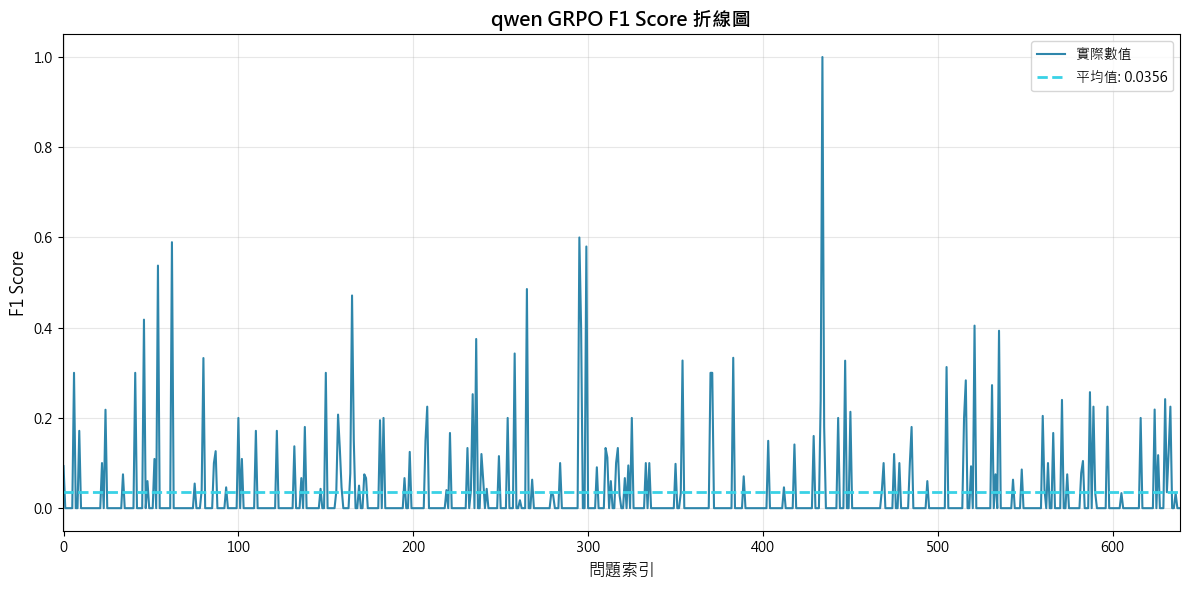

In [409]:

# 使用範例
if __name__ == "__main__":
    # 繪製 F1 Score 折線圖（第一列，無標頭）
    plot_line_from_csv(
        csv_file='qwen3_GRPO_F1.csv',
        col_index=2,
        xlabel='問題索引',
        ylabel='F1 Score',
        title='qwen GRPO F1 Score 折線圖',
        header=0,
        adjustment=0.2,
        filter=False
    )

F1 Score - 平均: 0.2393, 最大: 0.8889, 最小: 0.0000


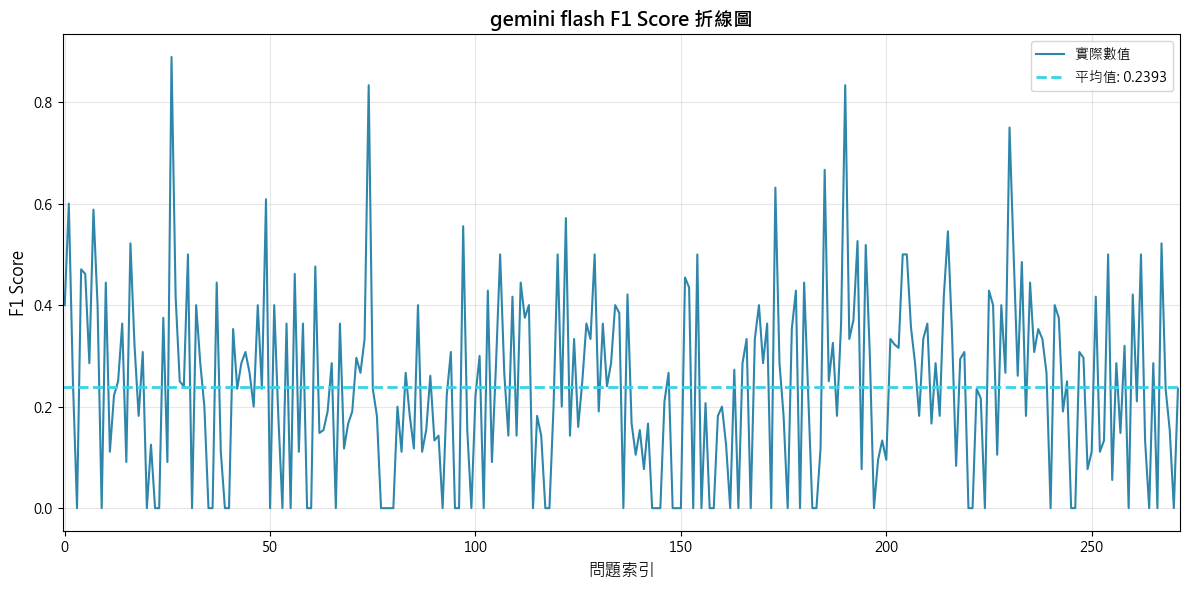

In [410]:
# 使用範例
if __name__ == "__main__":
    # 繪製 F1 Score 折線圖（第一列，無標頭）
    plot_line_from_csv(
        csv_file='gemini_flash_results.csv',
        col_index=0,
        xlabel='問題索引',
        ylabel='F1 Score',
        title='gemini flash F1 Score 折線圖',
        header=0,
        adjustment=1
    )

F1 Score - 平均: 0.2618, 最大: 0.8000, 最小: 0.0000


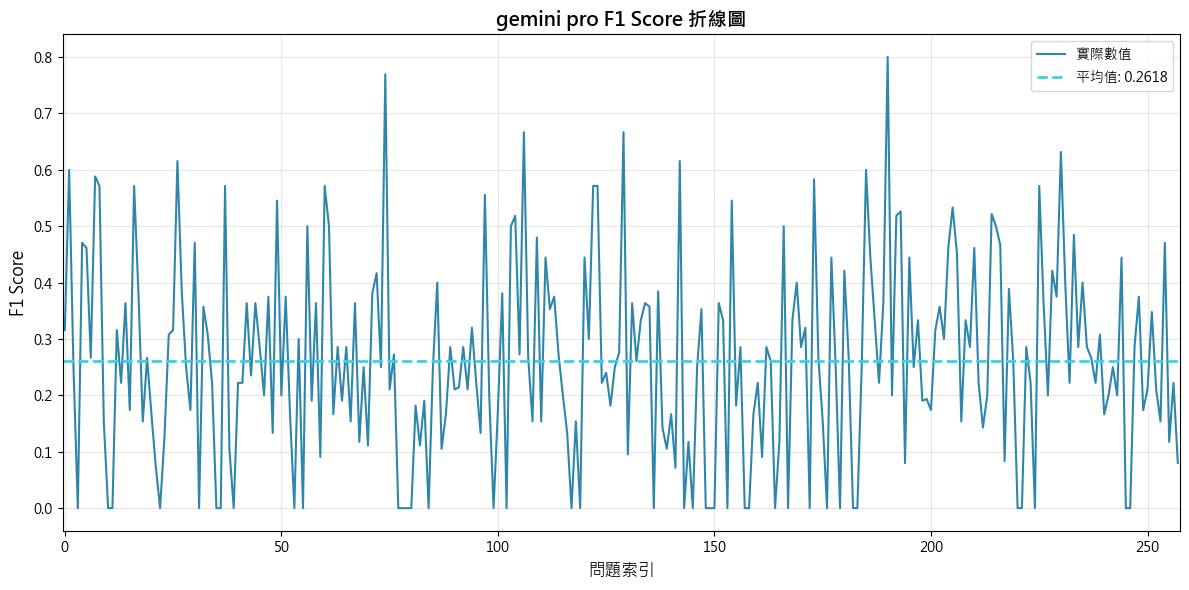

In [411]:
# 使用範例
if __name__ == "__main__":
    # 繪製 F1 Score 折線圖（第一列，無標頭）
    plot_line_from_csv(
        csv_file='gemini_pro_results.csv',
        col_index=0,
        xlabel='問題索引',
        ylabel='F1 Score',
        title='gemini pro F1 Score 折線圖',
        header=0,
        adjustment=1
    )

### 從多個 CSV 檔案讀取指定列並繪製在同一張折線圖上

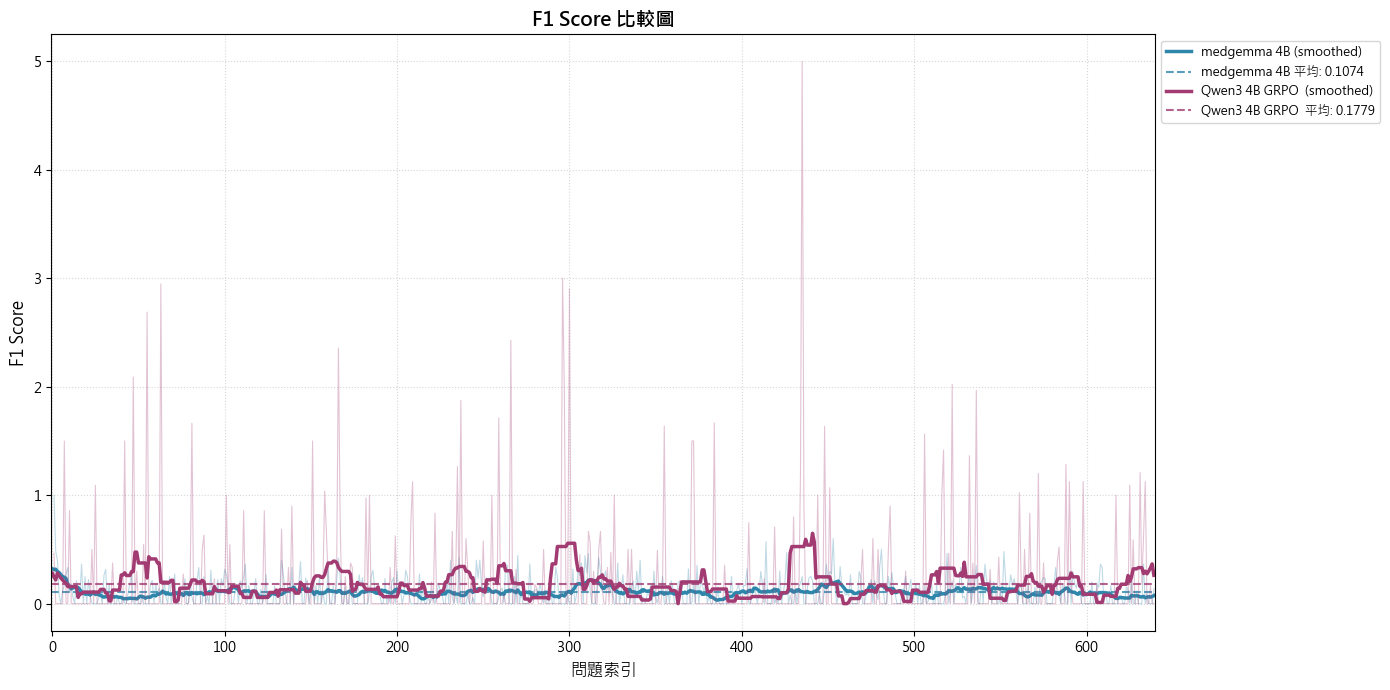

In [412]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_multiple_lines_from_csv(csv_configs, xlabel='索引', ylabel='數值', title='折線圖比較', filter=True, window_size=15):
    """
    優化版：加入移動平均線 (Moving Average) 以減少視覺雜訊
    window_size: 平滑化的窗口大小，數值越大越平滑
    """
    fig, ax = plt.subplots(figsize=(14, 7)) # 稍微加寬
    
    all_processed_data = []
    min_length = float('inf')
    
    # 第一步：讀取與過濾 (保持不變)
    for config in csv_configs:
        path = f"results/{config['csv_file']}"
        col_index = config['col_index']
        header = config.get('header', 0)
        df = pd.read_csv(path, header=header)
        
        if filter and 'filter_short_ground_truths' in globals():
            df = filter_short_ground_truths(df)
            
        data = pd.to_numeric(df.iloc[:, col_index], errors='coerce').values
        min_length = min(min_length, len(data))
        # min_length = 53
        all_processed_data.append({'data': data, 'config': config})

    # 第二步：繪圖優化
    for item in all_processed_data:
        config = item['config']
        label = config['label']
        color = config.get('color', None)
        data = item['data'][:min_length]
        x = np.arange(len(data))
        
        # 1. 計算移動平均 (使用 pandas rolling)
        # min_periods=1 確保在序列開始處也能計算
        smooth_data = pd.Series(data).rolling(window=window_size, center=True, min_periods=1).mean()
        
        # 2. 繪製背景原始數據 (降低透明度 alpha，縮小線寬)
        base_line = ax.plot(x, data, color=color, alpha=0.3, linewidth=0.8)
        current_color = color if color else base_line[0].get_color()
        
        # 3. 繪製平滑趨勢線 (加粗，不透明)
        ax.plot(x, smooth_data, color=current_color, linewidth=2.5, label=f'{label} (smoothed)')
        
        # 4. 計算並繪製平均值水平線
        data_clean = data[~np.isnan(data)]
        if len(data_clean) > 0:
            mean_value = data_clean.mean()
            ax.axhline(y=mean_value, color=current_color, linestyle='--', linewidth=1.5, 
                       alpha=0.8, label=f'{label} 平均: {mean_value:.4f}')

    # 設定細節
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.grid(True, which='both', linestyle=':', alpha=0.5)
    ax.set_xlim(-0.5, min_length - 0.5)
    
    # 將 Legend 放在圖外，避免遮擋數據
    ax.legend(fontsize=9, loc='upper left', bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    plt.show()
    return fig

# 使用範例
if __name__ == "__main__":
    # 比較兩個模型的 F1 Score
    plot_multiple_lines_from_csv(
        csv_configs=[
            {
                'csv_file': 'med_baseline.csv',
                'col_index': 0,
                'label': 'medgemma 4B',
                'header': None,
                'color': '#2E86AB'
            },
            {
                'csv_file': 'qwen3_GRPO_F1.csv',
                'col_index': 2,
                'label': 'Qwen3 4B GRPO ',
                'header': None,
                'adjustment': 0.2,
                'color': '#A23B72'
            }
        ],
        xlabel='問題索引',
        ylabel='F1 Score',
        title='F1 Score 比較圖',
        filter=False
    )

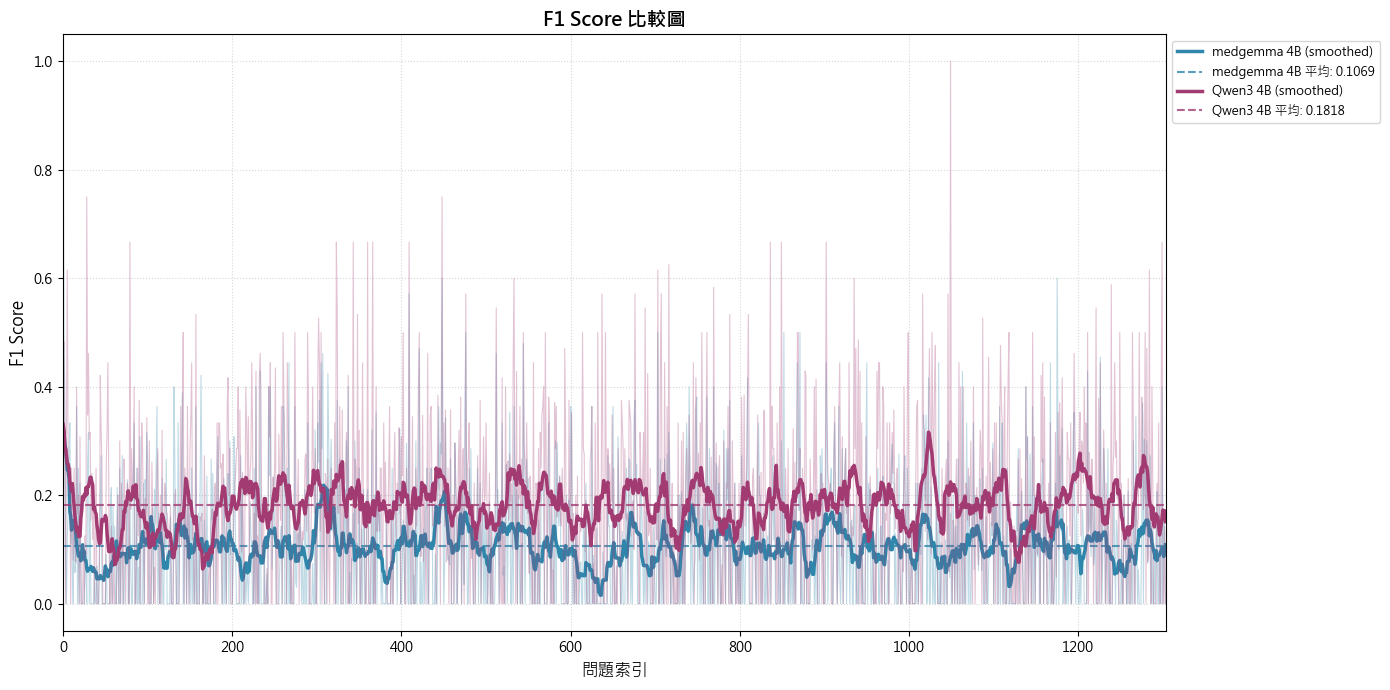

In [413]:
if __name__ == "__main__":
    # 比較兩個模型的 F1 Score
    plot_multiple_lines_from_csv(
        csv_configs=[
            {
                'csv_file': 'med_baseline.csv',
                'col_index': 0,
                'label': 'medgemma 4B',
                'header': 0,
                'color': '#2E86AB'
            },
            {
                'csv_file': 'qwen_baseline.csv',
                'col_index': 0,
                'label': 'Qwen3 4B',
                'header': 0,
                'color': '#A23B72'
            }
        ],
        xlabel='問題索引',
        ylabel='F1 Score',
        title='F1 Score 比較圖',
        filter=True
    )

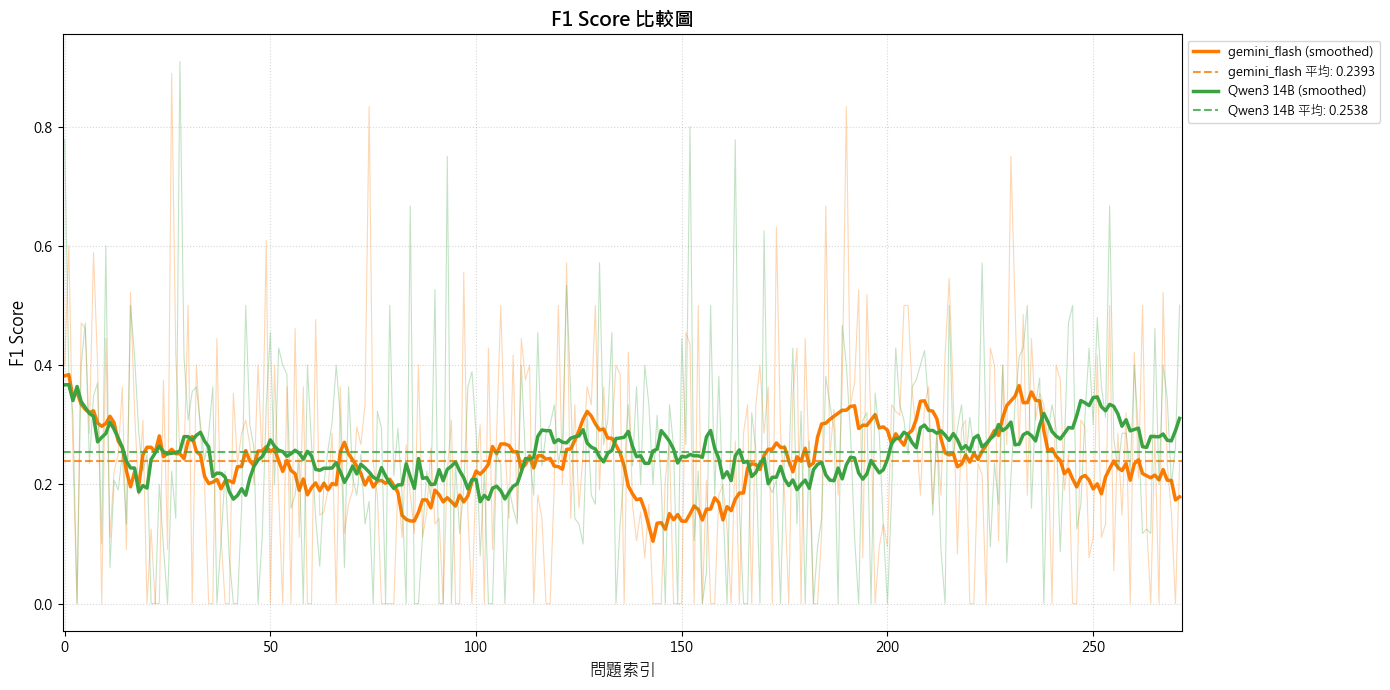

In [414]:
if __name__ == "__main__":
    # 比較兩個模型的 F1 Score
    plot_multiple_lines_from_csv(
        csv_configs=[
            {
                'csv_file': 'gemini_flash_results.csv',
                'col_index': 0,
                'label': 'gemini_flash',
                'header': 0,
                'color': "#FC7A00"
            },
            {
                'csv_file': 'qwen_baseline_14B.csv',
                'col_index': 0,
                'label': 'Qwen3 14B',
                'header': 0,
                'color': "#3BA242"
            }
        ],
        xlabel='問題索引',
        ylabel='F1 Score',
        title='F1 Score 比較圖',
        filter=True
    )

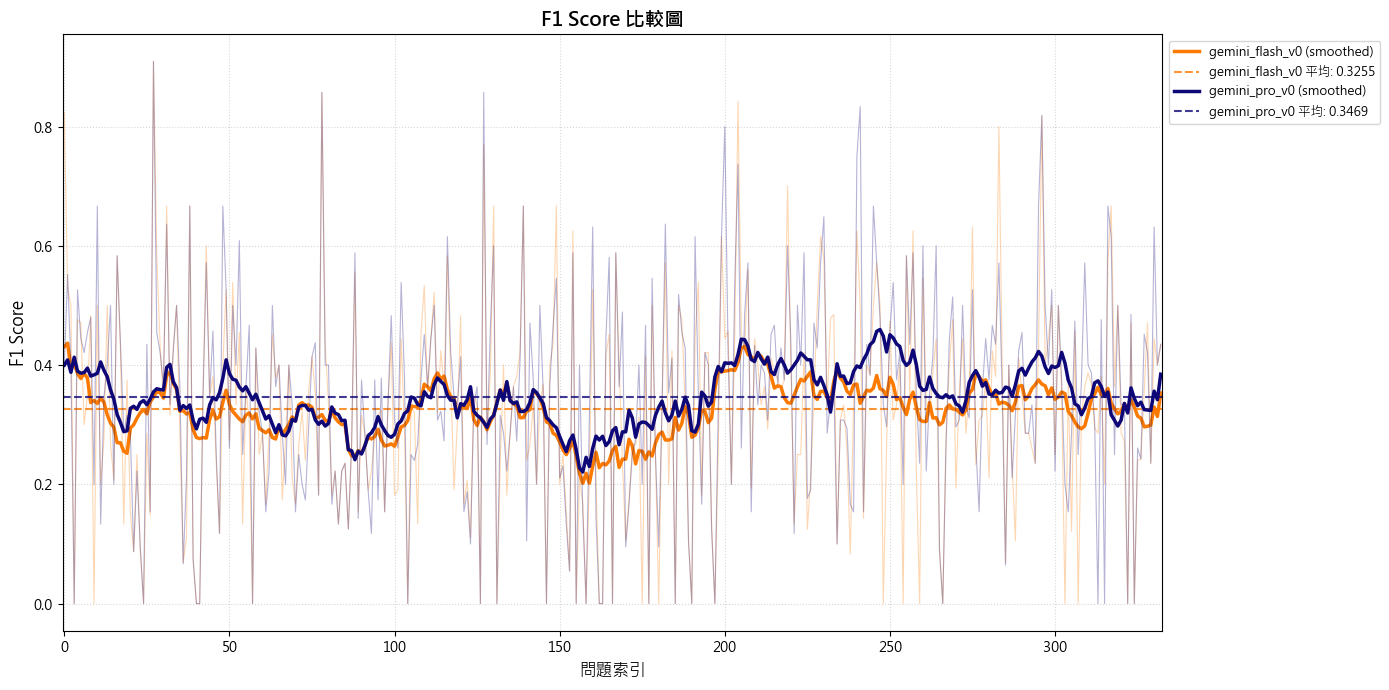

In [415]:
if __name__ == "__main__":
    # 比較兩個模型的 F1 Score
    plot_multiple_lines_from_csv(
        csv_configs=[
            {
                'csv_file': 'gemini_flash_results_v0.csv',
                'col_index': 0,
                'label': 'gemini_flash_v0',
                'header': 0,
                'color':  "#FC7A00"
            },
            {
                'csv_file': 'gemini_pro_results_v0.csv',
                'col_index': 0,
                'label': 'gemini_pro_v0',
                'header': 0,
                'color': "#0E0777"
            }
        ],
        xlabel='問題索引',
        ylabel='F1 Score',
        title='F1 Score 比較圖',
        filter=True
    )

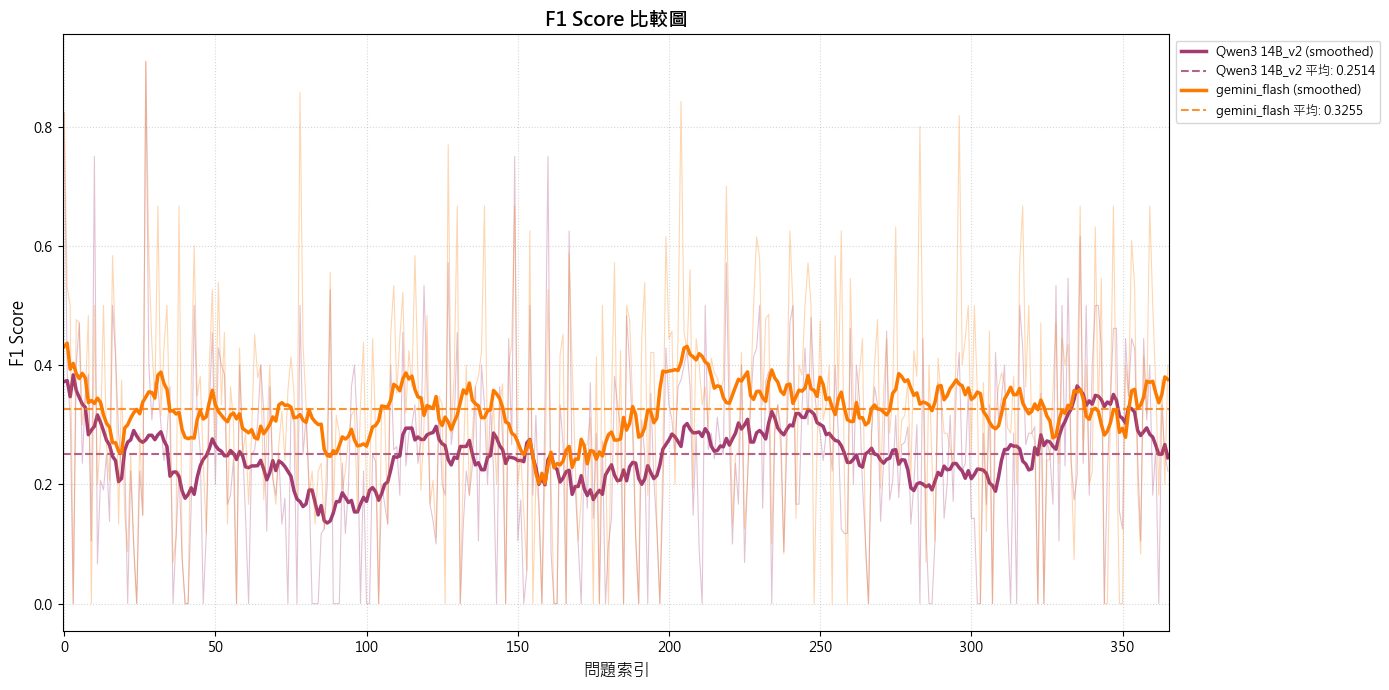

In [416]:
if __name__ == "__main__":
    # 比較兩個模型的 F1 Score
    plot_multiple_lines_from_csv(
        csv_configs=[
            {
                'csv_file': 'qwen_baseline_14B_v2.csv',
                'col_index': 0,
                'label': 'Qwen3 14B_v2',
                'header': 0,
                'color': '#A23B72'
            },
            {
                'csv_file': 'gemini_flash_results_v0.csv',
                'col_index': 0,
                'label': 'gemini_flash',
                'header': 0,
                'color':  "#FC7A00"
            }
        ],
        xlabel='問題索引',
        ylabel='F1 Score',
        title='F1 Score 比較圖',
        filter=True
    )

In [417]:
if __name__ == "__main__":
    # 比較兩個模型的 F1 Score
    plot_multiple_lines_from_csv(
        csv_configs=[
            {
                'csv_file': 'qwen_baseline_14B_v2.csv',
                'col_index': 0,
                'label': 'Qwen3 14B_v2',
                'header': 0,
                'color': '#A23B72'
            },
            {
                'csv_file': 'gemini_pro_results_v0.csv',
                'col_index': 0,
                'label': 'gemini_pro',
                'header': 0,
                'color':  "#0E0777"
            }
        ],
        xlabel='問題索引',
        ylabel='F1 Score',
        title='F1 Score 比較圖',
        filter=True
    )

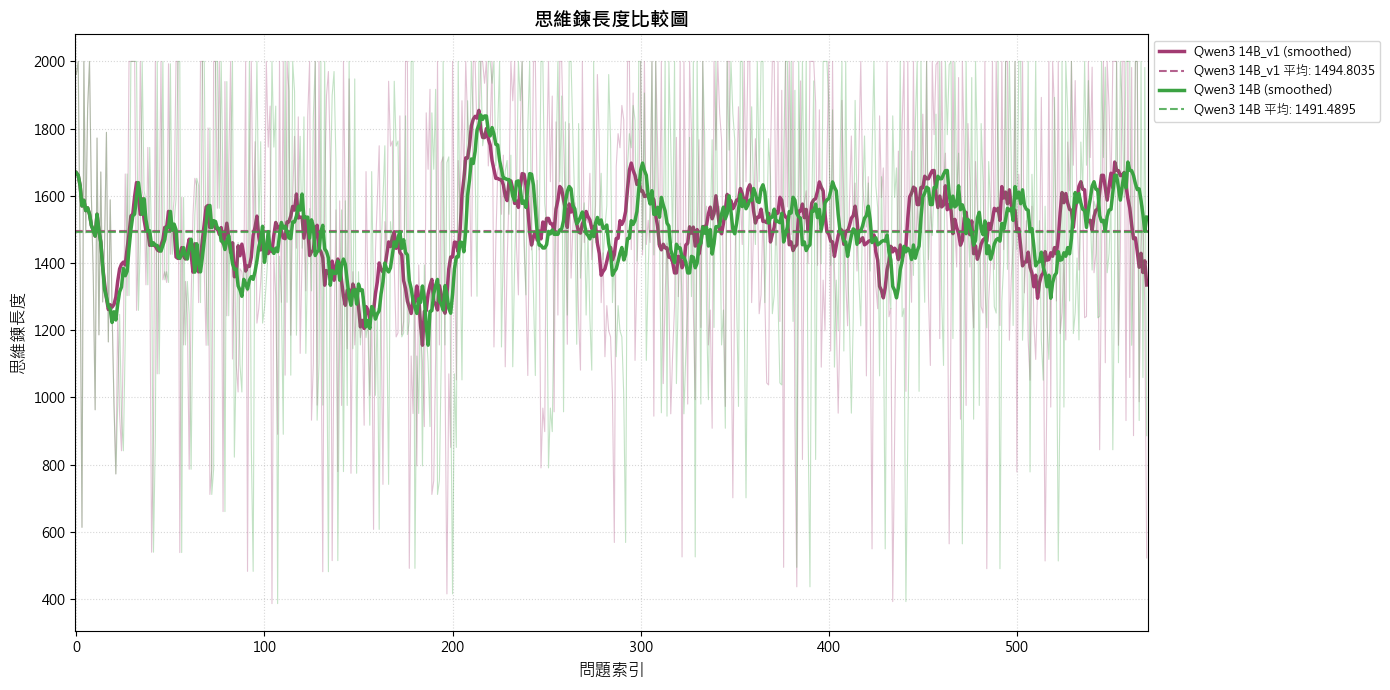

In [418]:
if __name__ == "__main__":
    # 比較兩個模型的 F1 Score
    plot_multiple_lines_from_csv(
        csv_configs=[
            {
                'csv_file': 'qwen_baseline_14B_v2.csv',
                'col_index': 1,
                'label': 'Qwen3 14B_v1',
                'header': 0,
                'color': '#A23B72'
            },
            {
                'csv_file': 'qwen_baseline_14B.csv',
                'col_index': 1,
                'label': 'Qwen3 14B',
                'header': 0,
                'color': "#3BA242"
            }
        ],
        xlabel='問題索引',
        ylabel='思維鍊長度',
        title='思維鍊長度比較圖',
        filter=True
    )

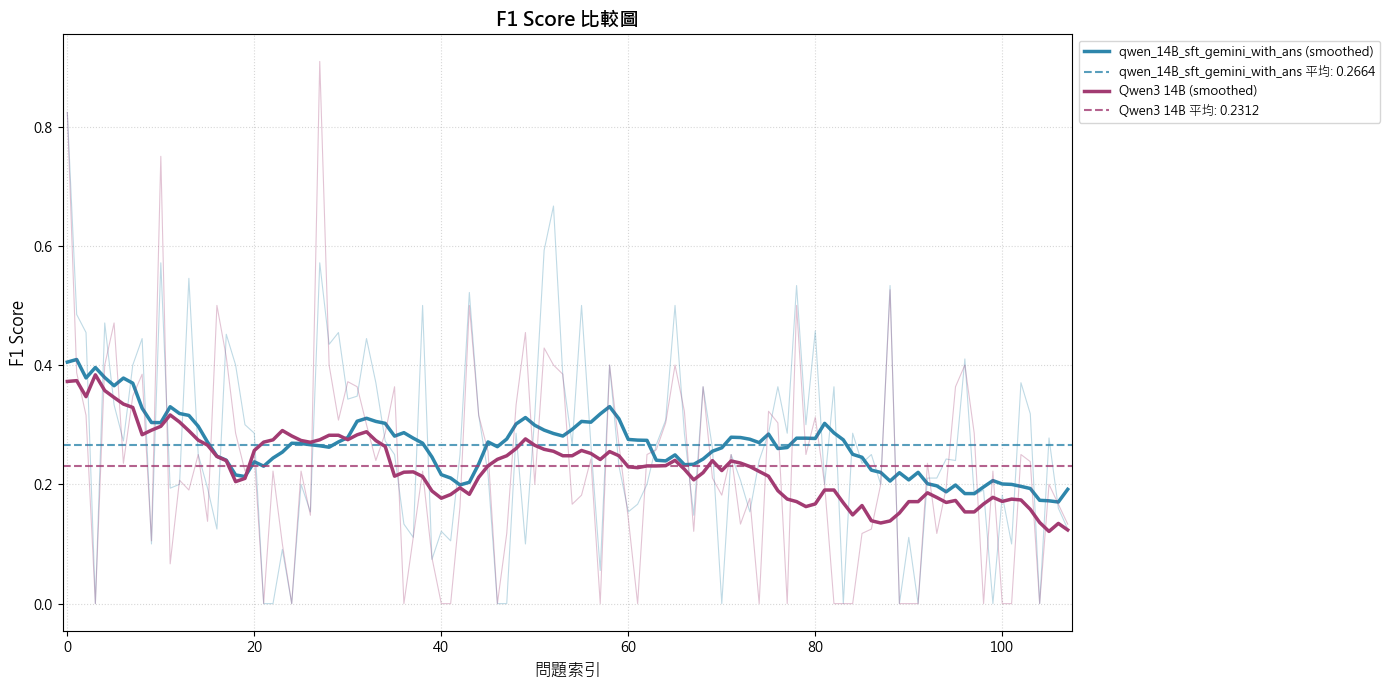

In [419]:
if __name__ == "__main__":
    # 比較兩個模型的 F1 Score
    plot_multiple_lines_from_csv(
        csv_configs=[
            {
                'csv_file': 'test_Qwen3-14B-sft_v1.csv',
                'col_index': 0,
                'label': 'qwen_14B_sft_gemini_with_ans',
                'header': 0,
                'color': '#2E86AB'
            },
            {
                'csv_file': 'qwen_baseline_14B_v2.csv',
                'col_index': 0,
                'label': 'Qwen3 14B',
                'header': 0,
                'color': '#A23B72'
            }
        ],
        xlabel='問題索引',
        ylabel='F1 Score',
        title='F1 Score 比較圖',
        filter=True
    )

### *

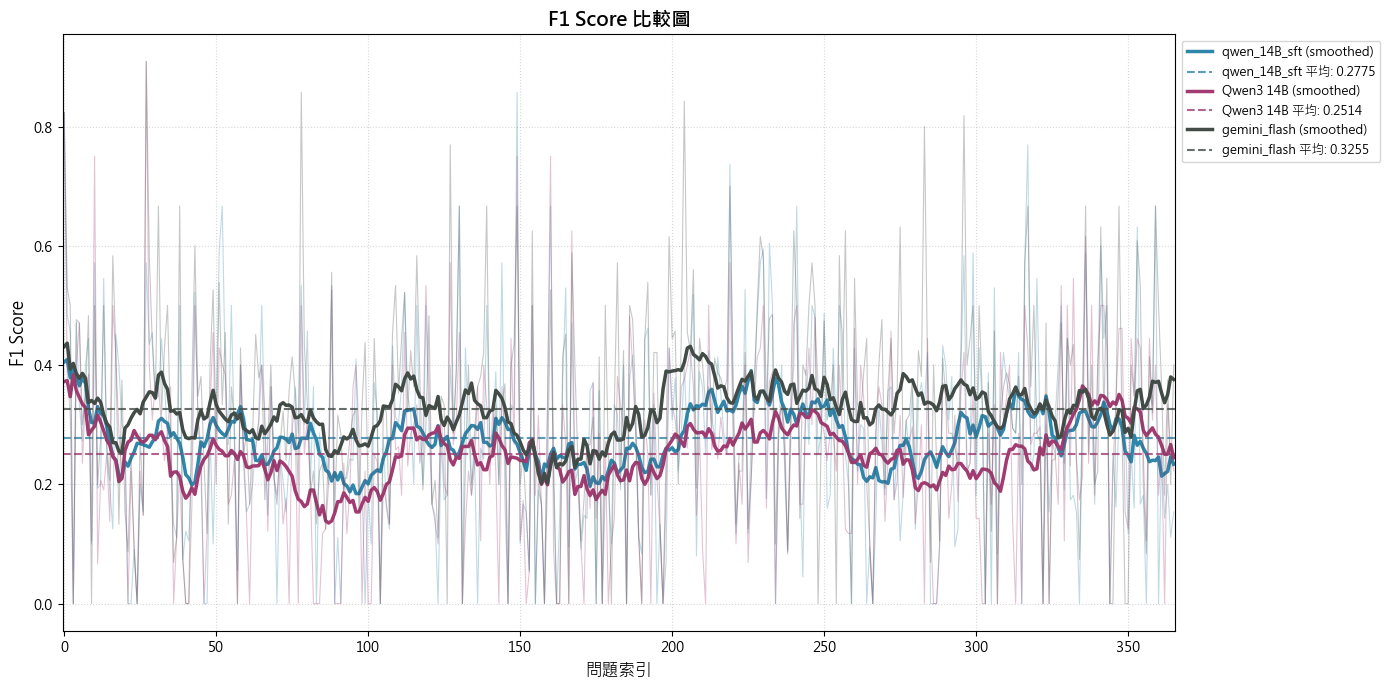

In [420]:
if __name__ == "__main__":
    # 比較兩個模型的 F1 Score
    plot_multiple_lines_from_csv(
        csv_configs=[
            {
                'csv_file': 'test_Qwen3-14B-sft_v1_1.csv',
                'col_index': 2,
                'label': 'qwen_14B_sft',
                'header': 0,
                'color': '#2E86AB'
            },
            {
                'csv_file': 'qwen_baseline_14B_v2.csv',
                'col_index': 0,
                'label': 'Qwen3 14B',
                'header': 0,
                'color': '#A23B72'
            },
                        {
                'csv_file': 'gemini_flash_results_v0.csv',
                'col_index': 0,
                'label': 'gemini_flash',
                'header': 0,
                'color':  "#424B45"
            }
        ],
        xlabel='問題索引',
        ylabel='F1 Score',
        title='F1 Score 比較圖',
        filter=True
    )

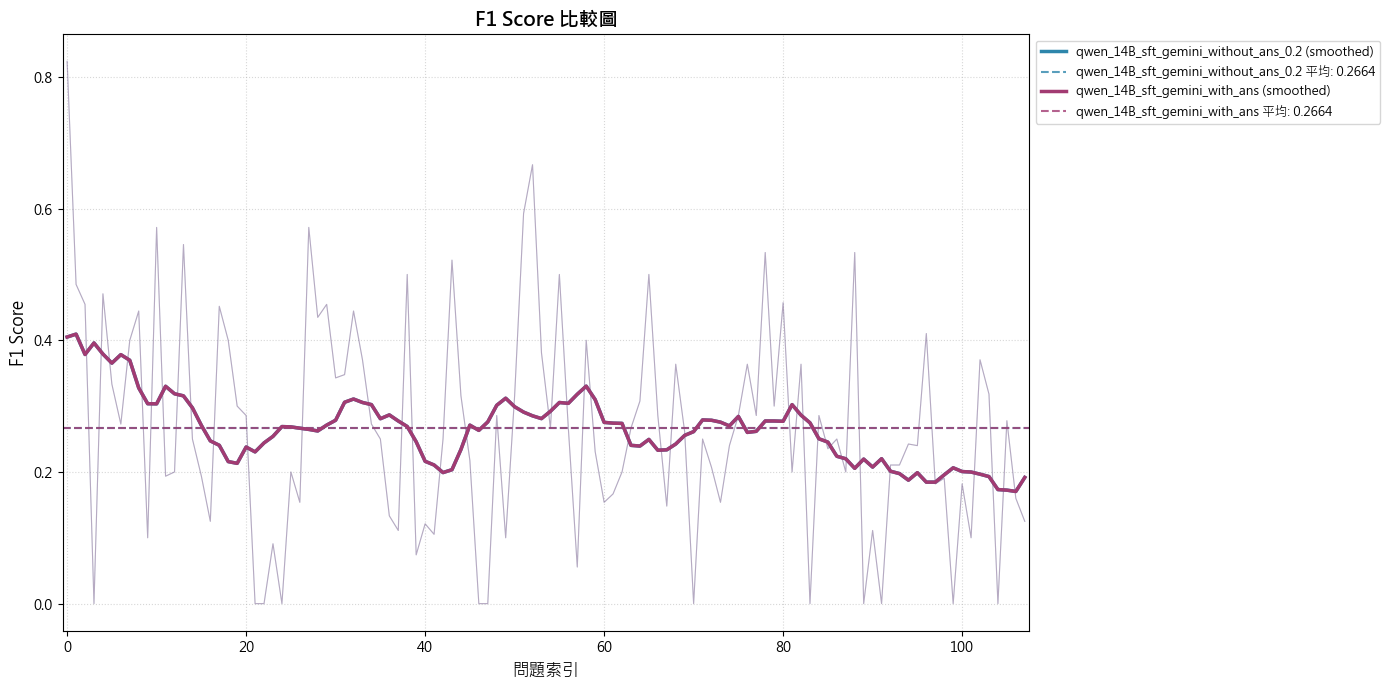

In [421]:
if __name__ == "__main__":
    # 比較兩個模型的 F1 Score
    plot_multiple_lines_from_csv(
        csv_configs=[
            {
                'csv_file': 'test_Qwen3-14B-sft_v1_1.csv',
                'col_index': 2,
                'label': 'qwen_14B_sft_gemini_without_ans_0.2',
                'header': 0,
                'color': '#2E86AB'
            },
            {
                'csv_file': 'test_Qwen3-14B-sft_v1.csv',
                'col_index': 0,
                'label': 'qwen_14B_sft_gemini_with_ans',
                'header': 0,
                'color': '#A23B72'
            }
        ],
        xlabel='問題索引',
        ylabel='F1 Score',
        title='F1 Score 比較圖',
        filter=True
    )

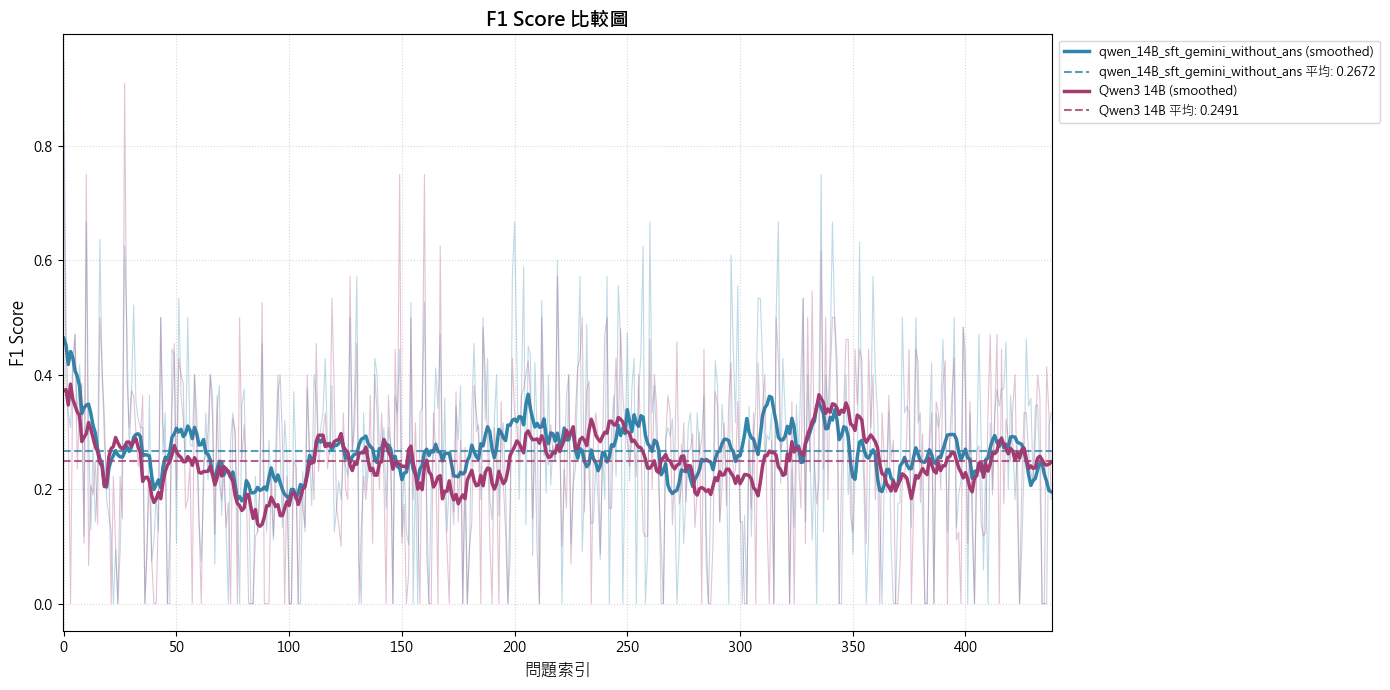

In [422]:
if __name__ == "__main__":
    # 比較兩個模型的 F1 Score
    plot_multiple_lines_from_csv(
        csv_configs=[
            {
                'csv_file': 'test_Qwen3-14B-sft_v2.csv',
                'col_index': 2,
                'label': 'qwen_14B_sft_gemini_without_ans',
                'header': 0,
                'color': '#2E86AB'
            },
            {
                'csv_file': 'qwen_baseline_14B_v2.csv',
                'col_index': 0,
                'label': 'Qwen3 14B',
                'header': 0,
                'color': '#A23B72'
            },
        ],
        xlabel='問題索引',
        ylabel='F1 Score',
        title='F1 Score 比較圖',
        filter=True
    )

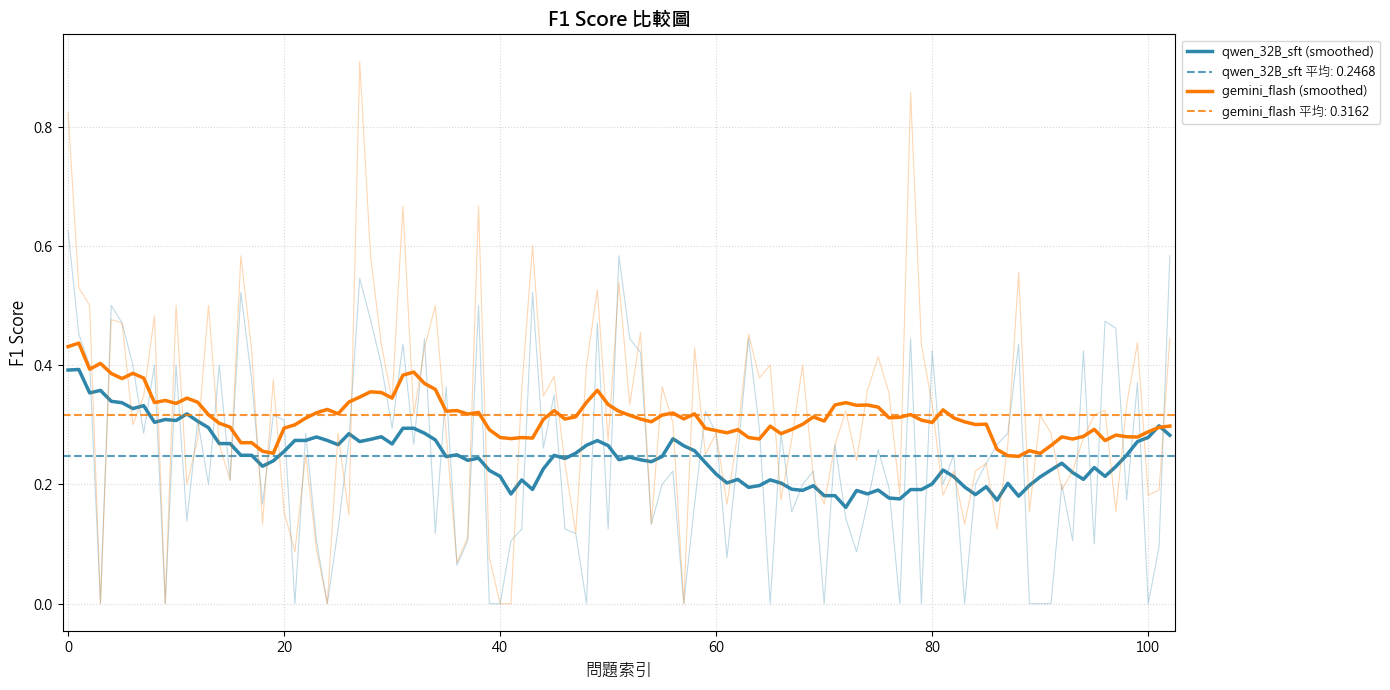

In [423]:
if __name__ == "__main__":
    # 比較兩個模型的 F1 Score
    plot_multiple_lines_from_csv(
        csv_configs=[
            {
                'csv_file': 'test_Qwen3-32B-sft.csv',
                'col_index': 2,
                'label': 'qwen_32B_sft',
                'header': 0,
                'color': '#2E86AB'
            },
            {
                'csv_file': 'gemini_flash_results_v0.csv',
                'col_index': 0,
                'label': 'gemini_flash',
                'header': 0,
                'color':  "#FC7A00"
            }
        ],
        xlabel='問題索引',
        ylabel='F1 Score',
        title='F1 Score 比較圖',
        filter=True
    )

In [424]:
if __name__ == "__main__":
    # 比較兩個模型的 F1 Score
    plot_multiple_lines_from_csv(
        csv_configs=[
            {
                'csv_file': 'test_Qwen3-14B-sft_v2.csv',
                'col_index': 2,
                'label': 'qwen_14B_sft_gemini_without_ans',
                'header': 0,
                'color': '#2E86AB'
            },
            {
                'csv_file': 'test_Qwen3-32B-sft.csv',
                'col_index': 2,
                'label': 'qwen_32B_sft',
                'header': 0,
                'color': "#AB2E9F"
            },
        ],
        xlabel='問題索引',
        ylabel='F1 Score',
        title='F1 Score 比較圖',
        filter=True
    )

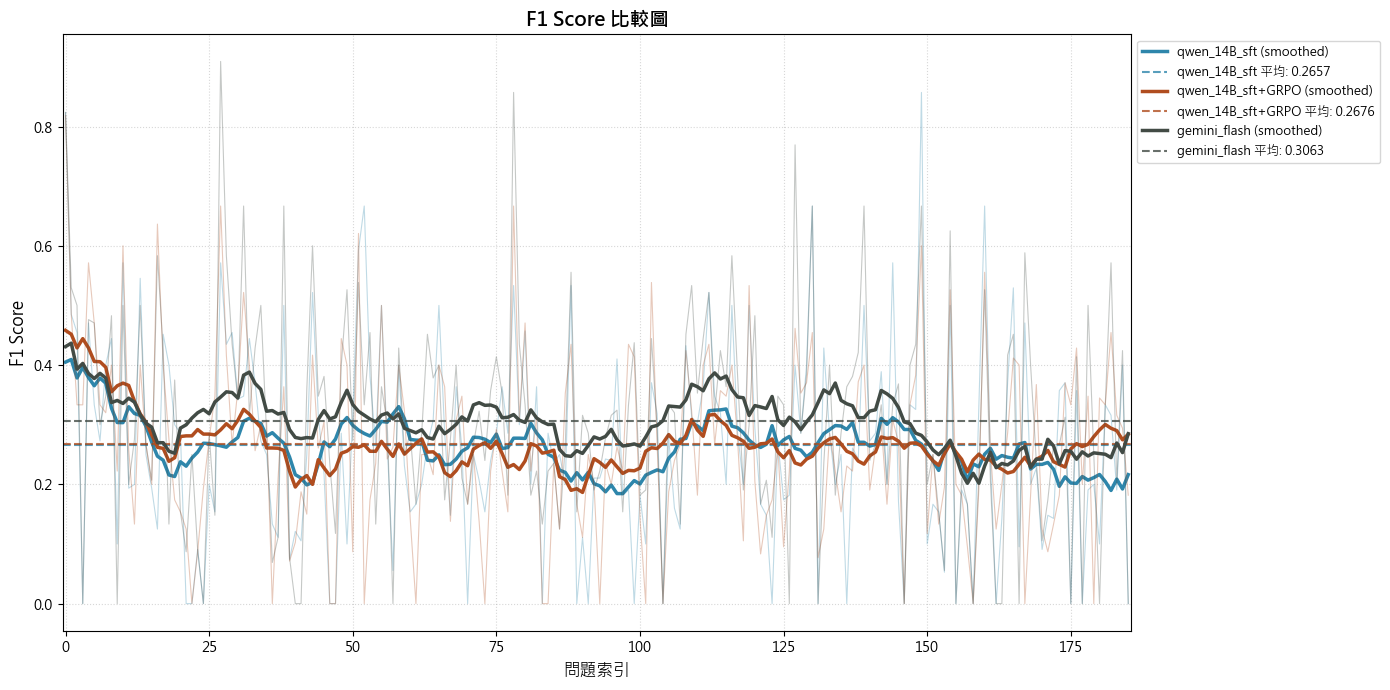

In [425]:
if __name__ == "__main__":
    # 比較兩個模型的 F1 Score
    plot_multiple_lines_from_csv(
        csv_configs=[
            {
                'csv_file': 'test_Qwen3-14B-sft_v1_1.csv',
                'col_index': 2,
                'label': 'qwen_14B_sft',
                'header': 0,
                'color': '#2E86AB'
            },
         {
                'csv_file': 'test_Qwen-14B-GRPO-sft.csv',
                'col_index': 2,
                'label': 'qwen_14B_sft+GRPO',
                'header': 0,
                'color':  "#B04D1F"
            },
                        {
                'csv_file': 'gemini_flash_results_v0.csv',
                'col_index': 0,
                'label': 'gemini_flash',
                'header': 0,
                'color':  "#424B45"
            }
        ],
        xlabel='問題索引',
        ylabel='F1 Score',
        title='F1 Score 比較圖',
        filter=True
    )

### debug

In [426]:
import pandas as pd

# 設定檔案路徑
file_path = r'results\test_Qwen3-32B-sft.csv'

try:
    # 讀取 CSV 檔案
    df = pd.read_csv(file_path)
    
    # 設定你想查看的索引 (Index)
    target_idx = 81

    # 檢查必要的欄位是否存在
    required_columns = ['assistant_reply', 'ground_truths_ans', 'accuracy_reward']
    missing_columns = [col for col in required_columns if col not in df.columns]

    if not missing_columns:
        # 檢查索引是否超出範圍
        if target_idx < len(df):
            print(f"--- 索引 {target_idx} 的詳細資訊 ---")
            print(f"【Assistant Reply】:\n{df['assistant_reply'][target_idx]}")
            print("-" * 30)
            print(f"【Ground Truth Ans】: {df['ground_truths_ans'][target_idx]}")
            print(f"【Accuracy Reward】 : {df['accuracy_reward'][target_idx]}")
        else:
            print(f"錯誤：索引 {target_idx} 超出資料範圍 (總長度 {len(df)})。")
    else:
        print(f"錯誤：檔案中缺少以下欄位：{missing_columns}")
        print(f"現有的欄位有：{df.columns.tolist()}")

except FileNotFoundError:
    print(f"錯誤：找不到檔案 '{file_path}'，請確認檔案路徑是否正確。")
except Exception as e:
    print(f"發生未預期的錯誤：{e}")

--- 索引 81 的詳細資訊 ---
【Assistant Reply】:
<think>

</think>

<reasoning>Step-by-step reasoning:
1.  **Chief Complaint: dyspnea, hypoxia** - This is the primary reason for the encounter. The patient's "chronic shortness of breath for years that worsened over the last ___ weeks" and "worsening BLE edema" indicate an acute exacerbation of a chronic condition. The "productive of sputum (whitish phlegm) and mild wheezing" further supports this.
2.  **PMH: CAD (Coronary Artery Disease)** - This is a chronic condition. The patient also has "CKD stage III" and "DM type II," which are comorbidities that can contribute to or complicate the current presentation.
3.  **PMH: COPD (Chronic Obstructive Pulmonary Disease)** - The patient has a history of COPD, and the "worsened over the last ___ weeks," "increased cough, productive of sputum (whitish phlegm) and mild wheezing," "URI symptoms, including sore throat and rhinorrhea the last few days," and "recently admitted from ___ for shortness of breath 

In [427]:
import pandas as pd

# 設定檔案路徑
file_path = r'results\test_Qwen-14B-GRPO-sft.csv'


try:
    # 讀取 CSV 檔案
    df = pd.read_csv(file_path)

    # 檢查 "accuracy reward" 欄位是否存在
    if 'assistant_reply' in df.columns:
        # 印出該欄位的數值
        print("--- Accuracy Reward 數值如下 ---")
        print(df['assistant_reply'])
    else:
        print(f"錯誤：檔案中找不到 'accuracy reward' 欄位。")
        print(f"現有的欄位有：{df.columns.tolist()}")

except FileNotFoundError:
    print(f"錯誤：找不到檔案 '{file_path}'，請確認檔案路徑是否正確。")
except Exception as e:
    print(f"發生未預期的錯誤：{e}")

--- Accuracy Reward 數值如下 ---
0      <think>\n\n</think>\n<reasoning>\n逐步推理：\n1.  *...
1      <think>\n\n</think>\n<reasoning>\n逐步推理：\n1.  *...
2      <think>\n\n</think>\n<reasoning>\n逐步推理：\n1.  *...
3      <think>\n\n</think>\n\n<reasoning>\n逐步推理：\n1. ...
4      <think>\n\n</think>\n<reasoning>\n逐步推理：\n1.  *...
                             ...                        
186    <think>\n\n</think>\n\n<reasoning>\n逐步推理：\n1. ...
187    <think>\n\n</think>\n\n<reasoning>\n逐步推理：\n1. ...
188    <think>\n\n</think>\n\n<reasoning>\n逐步推理：\n1. ...
189    <think>\n\n</think>\n<reasoning>\n逐步推理：\n1.  *...
190    <think>\n\n</think>\n\n<reasoning>\n逐步推理：\n1. ...
Name: assistant_reply, Length: 191, dtype: object
